In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve
import jax.numpy as jnp
from astropy import units as u
from astropy import constants as const
from Phase_curve_v1 import phase_curve, phase_angle, luminosity_bb, phase_planet
from Phase_curve_TTV import phase_TTV
from Orbital_motion import compute_true_anomaly
from Transits import eclipse, eclipse_impact_parameter, transit, transit_depth
from Solar_System_constants import R_Earth, R_Sun


In [2]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

{'planet_radius': np.float64(1.300241765), 'star_temperature': np.float64(3036.0), 'star_radius': np.float64(0.19), 'sma': np.float64(930498755.8), 'star_logg': np.float64(5.06), 'a/Rs': np.float64(7.039473728089088), 'Rp/Rs': np.float64(0.06273932352380034), 'albedo': 0.0, 'hrf': 0.6666666666666666, 'pos': 0.0, 'inclination': np.float64(88.5), 'mid_time': 2460000, 'eccentricity': 0.0, 'periastron': 0.0, 'period': np.float64(0.46292964), 'dayside_temperature': 1033, 'equilibrium_temperature': 809, 'nightside_temperature': 50, 'phase_curve_offset': 0.0}


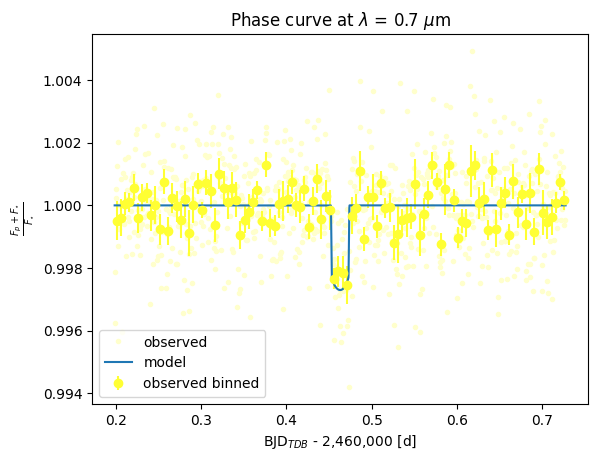

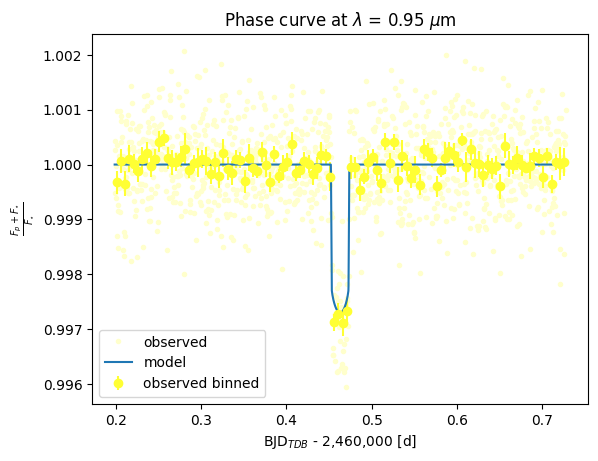

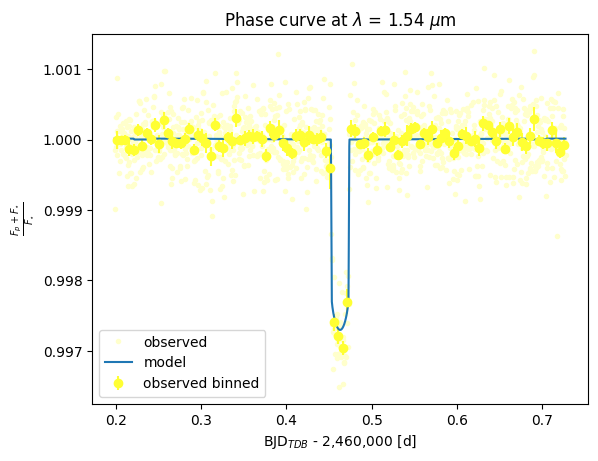

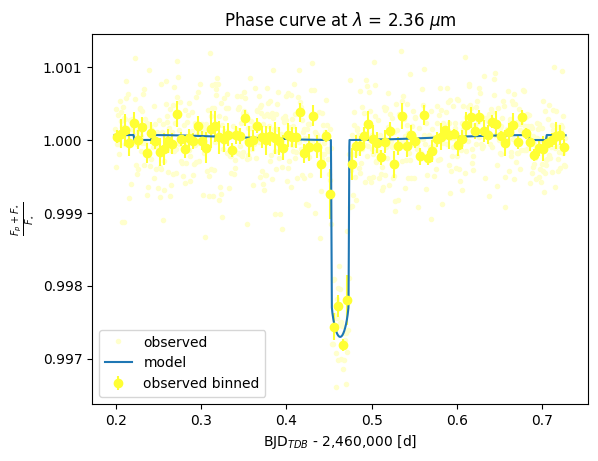

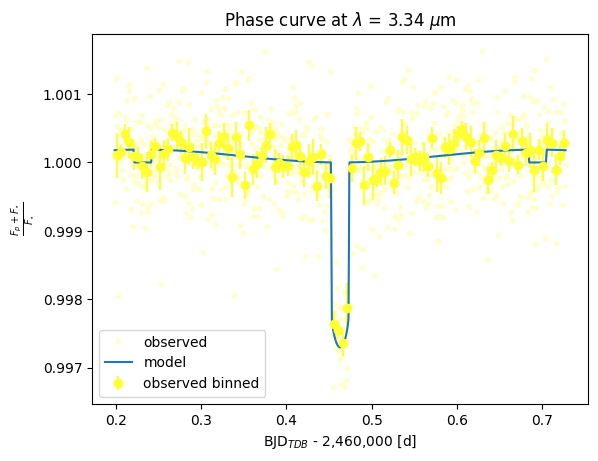

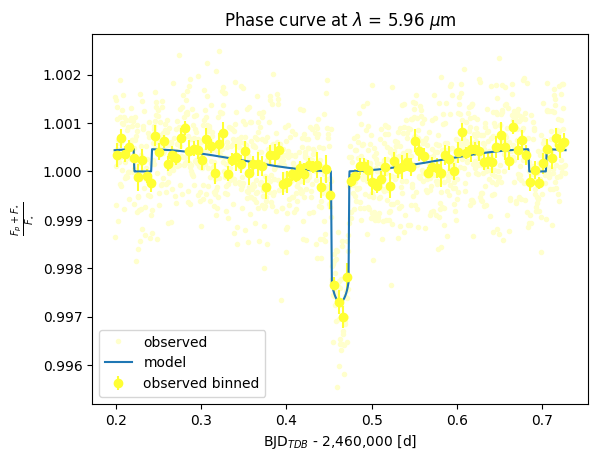

In [3]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")

print(df['input_parameters'])
data = df['input_parameters']

wvl = df['data'].keys()

for lamb in wvl:
    model_time = df['data'][lamb]['model']['time'] - 2460000
    model_phase = df['data'][lamb]['model']['phase']
    model_pc = df['data'][lamb]['model']['pc']
    observed_time = df['data'][lamb]['observed']['time'] - 2460000
    observed_phase = df['data'][lamb]['observed']['phase']
    observed_pc = df['data'][lamb]['observed']['pc']
    observed_binned = fast_binning(observed_time, observed_pc, 0.005)

    plt.figure()
    plt.plot(observed_time, observed_pc, '.', c=(1, 1, 0.8), label='observed')
    plt.errorbar(observed_binned[0], observed_binned[1], yerr=observed_binned[2], fmt='o', c=(1, 1, 0.2), label='observed binned')
    plt.plot(model_time, model_pc, label='model')
    plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
    plt.legend()
    plt.xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
    plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
    plt.show()

In [4]:
transit_duration_days = 0.5212/24
P=data['period']
time_transit=2458828.93037
impact_param=0.186
R_star = data['star_radius']*R_Sun
time_transit = 0
e = 0.0
omega = 0.0 # bcs e = 0
i = 90*np.pi/180 #data['inclination']*np.pi/180
a = 0.00622*149597870700 # a in m
R = data['planet_radius']*R_Earth
lambda_1 = 5.8
lambda_2 = 6.1
T_star = data['star_temperature']
L_star = luminosity_bb(T_star, lambda_1, lambda_2)
T_planet = data['dayside_temperature']
L = luminosity_bb(T_planet, lambda_1, lambda_2)
print(R/R_star)

0.06268184395093673


In [5]:
orbit = TransitOrbit(
    period=P, duration=transit_duration_days, time_transit=time_transit, impact_param=impact_param, radius_ratio=data['Rp/Rs'])

# Compute a limb-darkened light curve for this orbit
time = df['data'][lamb]['model']['time'] - 2460000
uu = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, uu)(time)

In [6]:
lamb = 5.96
model_time = df['data'][lamb]['model']['time'] - 2460000
model_pc = df['data'][lamb]['model']['pc']
observed_time = df['data'][lamb]['observed']['time'] - 2460000
observed_pc = df['data'][lamb]['observed']['pc']
observed_binned = fast_binning(observed_time, observed_pc, 0.01)

t0 = model_time[0]
t_end = model_time[len(model_time)-1]
nb_points = len(model_time)

phase = phase_planet
#phase = phase_planet(model_time, P)
nu = compute_true_anomaly(0,e,P,model_time)
alpha = phase_angle(omega,nu,i)
#b = eclipse_impact_parameter(a,i,e,R_star,omega)
b = impact_param
eclipsee = eclipse(P,a,R_star,R,i,phase,e,omega,b, model_time)

phase_curvee = phase_curve(L_star,L,R_star,R,phase(model_time, P),eclipsee)
phase_curvee = np.array(phase_curvee, dtype='float64')

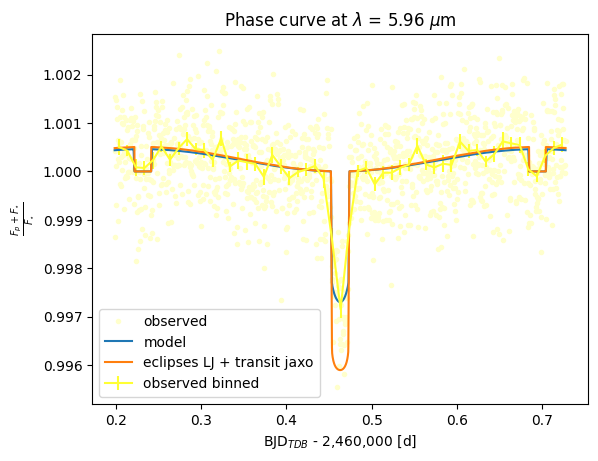

In [7]:
fig, ax = plt.subplots()
plt.plot(observed_time, observed_pc, '.', c=(1, 1, 0.8), label='observed')
plt.errorbar(observed_binned[0], observed_binned[1], yerr=observed_binned[2], c=(1, 1, 0.2), label='observed binned')
ax.plot(model_time, model_pc, label='model')
#ax.plot(model_time,phase_curvee, label='eclipses LJ')
ax.plot(model_time,phase_curvee + light_curve, label='eclipses LJ + transit jaxo')
#plt.plot(model_time,light_curve+1, label='transit jaxo')
ax.set_title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
ax.legend()
ax.set_xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
ax.set_ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()